In [1]:
%matplotlib widget

In [2]:
from SwarmModel import Swarm
from AsteroidModel import Asteroid,AsteroidField
from SatelliteModel import Satellite,Event
from GroundStationModel import GroundStation
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import imageio.v2 as imageio
from OrbitalElements import Orbit,Rotation
import os
import sys
import FunctionLibrary
import copy
im_path = "" # Set the directory path to store images or leave empty for current working directory

In [3]:
# Set the seed for random number generation used to generate various satellites and their parameters
rng = np.random.default_rng(5412) # default: 5412

In [4]:
def StandardTaskEventPDF(t,dt,k=0.98,MAX_TIME=100):
    '''Probability Distribution Function of the form:
        P(t) = k*(e^(-k*(-t+tmax))),
        Where:
        P(t) -> Probability of True event at time t
        t -> Time
        tmax -> Expected (maximum) time at which task is completed.
        k -> Factor
        At t = infinity (=tmax), P(t) = k. At t = 0, P(t) = 0'''
    #k = 0.98
    #MAX_TIME = 100
    if t > MAX_TIME:
        retVal = k
    else:
        retVal = k*(np.e**(-k*(-t+MAX_TIME)))
    return retVal

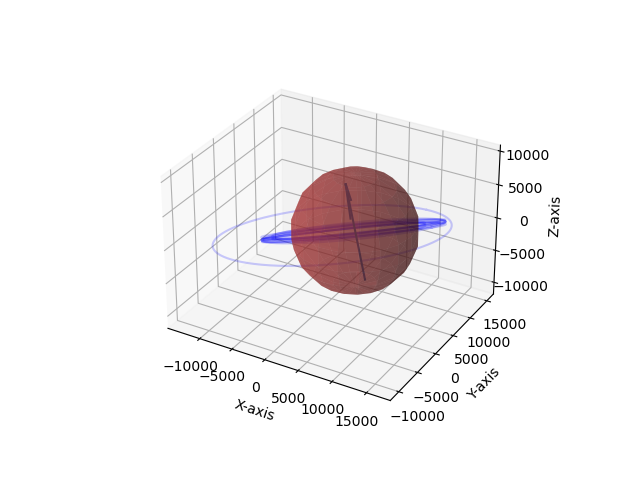

In [5]:
# Designing a swarm of 11 with 1 Leader, 6 Photogeologistic satellites, 2 Propsector satellites and 2 petrologist satellites
OrbitGeneratorRNG = np.random.default_rng(rng.integers(0,100000000,1)[0])

Eros = Asteroid(8420,6.687*(10**15),position=np.array([5000,2400,1500]),axis=np.array([-1.5,2,0.4]),period=316.2)
# Satellite Definition
satLeader = Satellite(0,np.array([0,0,0]))
satLeader2 = Satellite(1,np.array([0,0,0]))
satPhotogeologists = [Satellite(i,np.array([0,0,0])) for i in range (2,8)]
satPropsectors = [Satellite(i,np.array([0,0,0])) for i in range(8,10)]
satPetrologists = [Satellite(i,np.array([0,0,0])) for i in range(10,12)]
satelliteList = [satLeader,satLeader2]
satelliteList.extend(satPhotogeologists)
satelliteList.extend(satPropsectors)
satelliteList.extend(satPetrologists)
SmallSwarm = Swarm(satelliteList)
SmallSwarm.AddLeader(satLeader2)
_ = SmallSwarm.InitializeInformationMatrix()
_ = SmallSwarm.SetFollowerTriggerParameter(1/np.sqrt(SmallSwarm.SwarmSize))
_ = SmallSwarm.SetLeaderTriggerParameter(1/np.sqrt(SmallSwarm.SwarmSize))
ax,fig = Eros.PlotAsteroid(PlotAxis=True)

# Define orbits for each satellite

# Leader - Slightly below geostationary orbit around Eros. Orbit is marginally elliptic
#Leader = SmallSwarm.Leader[0]
rotation1 = Rotation('x',34)
rotation2 = Rotation('y',30)
rotation3 = Rotation('x',32)
rotation4 = Rotation('y',40)
rotations=[rotation1,rotation2]
rotations2 = [rotation3,rotation4]
SmallSwarm.Leader[0].DefineOrbit(Orbit(Eros.GeoRadius-50,e=0.25,OrbitalPoints=1440,\
                                        Rotations=rotations))
SmallSwarm.Leader[0].Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(SmallSwarm.Leader[0].Orbit.Radius)
SmallSwarm.Leader[0].ComputeOrbitParameters(SmallSwarm.Leader[0].Orbit.OrbitalPeriod)
SmallSwarm.Leader[0].Orbit.ShiftOrbit(0)
ax,fig = Eros.PlotSatelliteOrbit(SmallSwarm.Leader[0],ax,fig)
SmallSwarm.Leader[1].DefineOrbit(Orbit(Eros.GeoRadius-50,e=0.25,OrbitalPoints=1440,\
                                        Rotations=rotations2))
SmallSwarm.Leader[1].Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(SmallSwarm.Leader[1].Orbit.Radius)
SmallSwarm.Leader[1].ComputeOrbitParameters(SmallSwarm.Leader[1].Orbit.OrbitalPeriod)
SmallSwarm.Leader[1].Orbit.ShiftOrbit(0)

# Photogeologists - consist of Narrow Field and Wide Field Imagers and Altimeter separated by tens of kilometers to
# kilometers which would be used to determine the nature and distribution of geological units based on texture, albedo,
# color, and apparent stratigraphy as expressed on the surface, from which the nature of the dynamic history and origin
# of the object could be inferred.
for ID in range(2,8):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(35,45,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(35,45,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(12000+OrbitGeneratorRNG.integers(-20,20,1)[0],e=0.02,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)
            
            

# Prospectors - consist of altimeter, magnetometer, Near Infrared, Infrared, and X-ray spectrometers separated
# by tens of kilometers to kilometers which could be used to determine the distribution of 'resources', including Fe/Ni and
# volatiles on pre-selected candidates for 'mining
for ID in range(8,10):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(40,46,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(40,46,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(11500 + OrbitGeneratorRNG.integers(-20,21,1)[0],e=0.05,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)

# Petrologists - Consist of X-ray, Near Infrared, Gamma-ray, Thermal IR, and wide field imager separated by tens of kilometers 
# to kilometers which would be used to determine the abundances and distribution of elements, minerals, and rocks present, 
# from which the nature of geochemical differentiation, origin, and history of the object, and its relationship to a
# 'parent body' could be inferred.
for ID in range(10,12):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(32,40,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(32,40,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(10000 + OrbitGeneratorRNG.integers(-20,21,1)[0],e=0.1,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)

In [6]:
# Defining the Probability Distribution Function
def UnitImpulsePDF(t,dt,tOrbit,margin):
    '''Impulse function at t = tOrbit. Linear increase from tOrbit +- margin from 90% to 100%'''
    retVal = 0
    lowerBound = tOrbit - margin
    upperBound = 0 + margin # Modular arithmetic
    tMod = (t) % int(tOrbit)
    if (tMod <= upperBound):
        difference = tMod
    elif (tMod >= lowerBound):
        difference = tOrbit - tMod
    else:
        return retVal
    
    retVal = 0 + ((margin-difference)/(1*margin))
    return retVal

def HardwareFailureEventPDF(t,dt,fMin=0.002,tStart=0,slope=0.0002,maxVal=1):
    '''Follows a bathtub curve beginning after the initial slope down'''
    retVal = 0
    if t < tStart:
        retVal = fMin
    else:
        retVal = slope * (t - tStart) + fMin
        
    if retVal > maxVal:
        retVal = maxVal
    return retVal

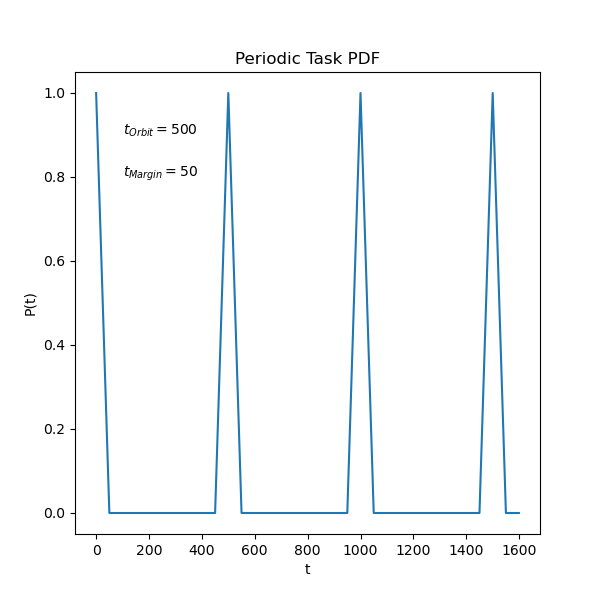

In [7]:
xVal = []
yVal = []
for t in range(0,1600):
    xVal.append(t)
    yVal.append(UnitImpulsePDF(t,0,500,50))
plt.figure(figsize=(6,6))
plt.plot(xVal,yVal)
plt.text(100,0.9,"$t_{Orbit}=500$")
plt.text(100,0.8,"$t_{Margin}=50$")
plt.xlabel("t")
plt.ylabel("P(t)")
plt.title("Periodic Task PDF")
plt.show()

In [8]:
# Satellite Event Definitions
eventRNG = np.random.default_rng(rng.integers(0,10000000,1)[0])
PositionNoiseRNG_X = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Y = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Z = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
# 1. Task Completion Events : Valid for follower satellites only, Leader has a dummy task
#StandardTaskEvent = Event(Name="Standard",Priority=lambda x:0.8,Threshold=lambda x:0.9,\
#                              PDF=StandardTaskEventPDF,AdditionalArguments=(k,TMax),ThresholdType='VAR')

# 0. Leader - No specific end task, say 1 month
tMax = 43200
CompletionEvent1 = Event(Name="L1_Task",Priority=lambda x:5, Threshold=lambda x:0.9,\
                       PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
tMax = 45000
CompletionEvent2 = Event(Name="L2_Task",Priority=lambda x:5, Threshold=lambda x:0.9,\
                       PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
SmallSwarm.Leader[0].AddEvents(CompletionEvent1)
SmallSwarm.Leader[1].AddEvents(CompletionEvent2)
# a. Photogeologist - Task completion in the range of 24000 minutes
PhotoGeologistTaskCompletionList = []
for i in range(1,7):
    tMax = 24000 + eventRNG.integers(-2400,2401,1)[0]
    CompletionEvent = Event(Name=f"PG{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                                   PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    PhotoGeologistTaskCompletionList.append(CompletionEvent)
    
# b. Prospector - Task completion event in the range of 30000 minutes
ProspectorTaskCompletionList = []
for i in range(1,3):
    tMax = 30000 + eventRNG.integers(-3000,3001,1)[0]
    CompletionEvent = Event(Name=f"PR{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                           PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    ProspectorTaskCompletionList.append(CompletionEvent)

# c. Petrologist - Task completion event in the range of 20000 minutes
PetrologistTaskCompletionList = []
for i in range(1,3):
    tMax = 20000 + eventRNG.integers(-2000,2001,1)[0]
    CompletionEvent = Event(Name=f"PE{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                            PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    PetrologistTaskCompletionList.append(CompletionEvent)
TaskCompletionEvents = []
TaskCompletionEvents.extend(PhotoGeologistTaskCompletionList)
TaskCompletionEvents.extend(ProspectorTaskCompletionList)
TaskCompletionEvents.extend(PetrologistTaskCompletionList)
for i in range(2,12):
    SmallSwarm.Members[i].AddEvents(TaskCompletionEvents[i-2])
# 2. Orbit completion events : Valid for all satellites


# Satellite specific orbit completion events
OrbitCompletionEvents = []
matchDict = {0:'L',1:'PG',2:'PG',3:'PG',4:'PG',5:'PG',6:'PG',7:'PR',8:'PR',9:'PE',10:'PE',11:'PE'}
for satellite in (SmallSwarm.Members):
    OrbitEvent = Event(Name=f"{matchDict[satellite.ID]}_Orbit",Priority=lambda x:0.1,Threshold=lambda x:0.95,\
                      PDF=UnitImpulsePDF,\
                       AdditionalArguments=(int(satellite.Orbit.OrbitalPeriod),500),\
                       HoldTime=0)#(satellite.Orbit.OrbitalPeriod//1000))
    OrbitCompletionEvents.append(OrbitEvent)
    # Attach event to satellite
    satellite.AddEvents(OrbitEvent)

# 3. Critical Hardware Failure events : Valid for all satellites
HWFailureEvents = []
for satellite in (SmallSwarm.Members):
    HWFailureEvent = Event(Name=f"{matchDict[satellite.ID]}{satellite.ID}_HWF",Priority=lambda x:1,Threshold=lambda x:0.9,\
                          PDF=HardwareFailureEventPDF,AdditionalArguments=(0.0002,40000,0.00001),\
                           RNG=np.random.default_rng(eventRNG.integers(0,100000,1)[0]),ThresholdType='FIXED')
    # Attach event to satellite
    satellite.AddEvents(HWFailureEvent)
    
# 4. Data offload to Leader events: Valid for follower satellites only
for satellite in (SmallSwarm.Members):
    if satellite not in SmallSwarm.Leader:
        DataEvent = Event(Name=f"{matchDict[satellite.ID]}{satellite.ID}_DO",Priority=lambda x:5,Threshold=lambda x:0.8,\
                          PDF=UnitImpulsePDF,AdditionalArguments=(6000,400),\
                          RNG=np.random.default_rng(eventRNG.integers(0,100000,1)[0]),ThresholdType='FIXED',HoldTime=600)
        satellite.AddEvents(DataEvent)

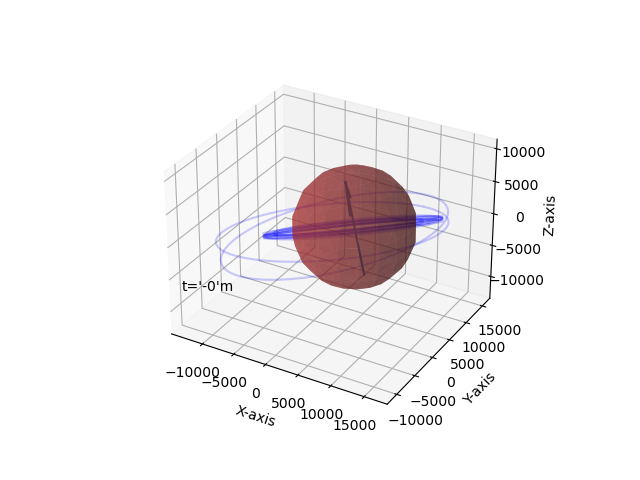

In [9]:
# Simulate a few orbits of the Leader satellite
SIMULATION_TIME = 1000
SAMPLING_TIME = 10
SAVE_IMG = False
_ = SmallSwarm.InitializeInformationMatrix()
_ = SmallSwarm.SetFollowerTriggerParameter(0.55)
_ = SmallSwarm.SetLeaderTriggerParameter(1)
X0 = Eros.Position[0]
Y0 = Eros.Position[1]
Z0 = Eros.Position[2]
count = 0
t="-0"
ax,fig = Eros.PlotAsteroid(PlotAxis=True)
for satellite in SmallSwarm.Members:
    ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)
text = ax.text(-12000,-14000,-5000,f"{t=}m")
for t in range(0,SIMULATION_TIME,SAMPLING_TIME):
    tLoc = t
    _ = SmallSwarm.CheckEvents(tLoc)
    X = []
    Y = []
    Z = []
    for satellite in SmallSwarm.Members:
        # Plotting - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        tSat = (t) % int(satellite.Orbit.OrbitalPeriod)
        OrbitValues = satellite.Orbit.GetOrbitValues()
        tValues = satellite.Orbit.GetTimeValues()
        Xf = satellite.Orbit.GetFociValues()[0][0]
        Yf = satellite.Orbit.GetFociValues()[0][1]
        Zf = satellite.Orbit.GetFociValues()[0][2]
        if tSat in tValues:
            tValIndex = tValues.index(tSat)
        else:
            for index,time in enumerate(tValues):
                if tSat>time and tSat<(tValues[(index+1)%len(tValues)]):
                    tValIndex = index
                    break
        Xs = OrbitValues[tValIndex][0]
        Ys = OrbitValues[tValIndex][1]
        Zs = OrbitValues[tValIndex][2]
        XC = Xs - Xf + X0
        YC = Ys - Yf + Y0
        ZC = Zs - Zf + Z0
        coord = np.array([XC,YC,ZC])
        satellite.Position = coord
        X.append(XC)
        Y.append(YC)
        Z.append(ZC)
    if SAVE_IMG == True:
        colors =['blue'] * SmallSwarm.SwarmSize
        colors[0],colors[1] = 'red','red'
        colors[2],colors[3],colors[4],colors[5],colors[6],colors[7] = 'orange','orange','orange','orange','orange','orange'
        colors[8],colors[9] = 'green','green'
        colors[10],colors[11] = 'black','black'
        scat_plot = ax.scatter(X,Y,Z,c=colors,marker='o')
        text.set_text(f"{t=}m")
        ax.set_aspect('equal',anchor='C')
        plt.savefig(im_path+str(count)+".png")
        count+=1
        scat_plot.remove()
    # Plotting - END %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Information Matrix - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for satellite in SmallSwarm.Members: # k
        for row in range(0,SmallSwarm.SwarmSize): # Self Satellite , i
            rowSat = SmallSwarm.GetSatelliteByID(row)
            for col in range(0,SmallSwarm.SwarmSize): # Other Satellite, j
                colSat = SmallSwarm.GetSatelliteByID(col)
                if ((satellite.ID == rowSat.ID) and (rowSat.ID == colSat.ID)): # Self Self-Information, i = j = k, all
                        #Self Information Calculation - START
                    AlphaVal = round(1/(len(satellite.Events)+1),4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,0.5),4),\
                                            round(PositionNoiseRNG_Y.normal(0,0.5),4),\
                                            round(PositionNoiseRNG_Z.normal(0,0.5),4)])
                    _ = satellite.UpdateSelfInformationFactor(Alpha=AlphaVal,Beta=BetaVal,Time=tLoc,\
                                                                    Noise=NoiseInfo,dMax=50)
                    #Self Information Calculation - END

                elif ((row == col) and (satellite.ID != row)\
                        and ((satellite in SmallSwarm.Leader)or \
                            (colSat in SmallSwarm.Leader))): # Other Self-Information, i = j != k, only if you or other is leader

                    # Update (Other) Self-Information Calculation - START
                    NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,5),4),\
                                            round(PositionNoiseRNG_Y.normal(0,5),4),\
                                            round(PositionNoiseRNG_Z.normal(0,5),4)])
                    NoiseFactor = np.array([1,1,1])
                    AlphaVal = round(1/(len(rowSat.Events)+1),4)
                    BetaVal = AlphaVal
                    _ = satellite.UpdateOtherSelfInformationFactor(InSat=rowSat,Noise=NoiseInfo,NoiseFactor=NoiseFactor,\
                                                                dMax=50,Estimate=True,Beta=BetaVal)
                        # Update (Other) Self-Information Calculation - END

                    # Cross Information Factors - What you know about them
                    # Satellite is Leader, Self is Satellite
                elif ((satellite in SmallSwarm.Leader) and (col == satellite.ID) and (row != col)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                   dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)
                    # I've given up on describing these situations
                elif ((satellite not in SmallSwarm.Leader) and (col == satellite.ID) and \
                    (rowSat in SmallSwarm.Leader) and (row != col)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)

                    # Cross Information Factors - What they know about you    
                elif((satellite in SmallSwarm.Leader) and (row == satellite.ID) and (row != col)):
                    AlphaVal = 1/(len(satellite.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal,\
                                                                    Invert=True)

                elif ((rowSat in SmallSwarm.Leader) and (rowSat != satellite) and (satellite in SmallSwarm.Leader)):
                    AlphaVal = 1/(len(colSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                            PositionNoiseRNG_Y.normal(0.0,10),\
                                            PositionNoiseRNG_Z.normal(0.0,10)])
                    _ = satellite.UpdateOtherCrossInformationFactor(InSat=rowSat,InSat2=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                    dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=colSat.MaximumTransmitInterVal)
                elif ((colSat in SmallSwarm.Leader) and (colSat != satellite) and (satellite in SmallSwarm.Leader)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    BetaVal = AlphaVal
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = round(BetaVal,4)
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                            PositionNoiseRNG_Y.normal(0.0,10),\
                                            PositionNoiseRNG_Z.normal(0.0,10)])
                    _ = satellite.UpdateOtherCrossInformationFactor(InSat=colSat,InSat2=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                    dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)
                      
    # Update Information Matrix Log - START
        _ = satellite.CheckInformationMatrixJacobian()
        _ = satellite.StoreInformationMatrix()
    # Update Information Matrix Log - END
#plt.show()
if SAVE_IMG:
    images = []
    for filename in range(0,count):
        images.append(imageio.imread(im_path + str(filename)+".png"))
    imageio.mimsave(im_path + 'SmallSwarm_Orbit_4.gif', images)
    for filename in range(0,count):
        if os.path.exists(im_path + str(filename)+".png"):
            os.remove(im_path + str(filename)+".png")

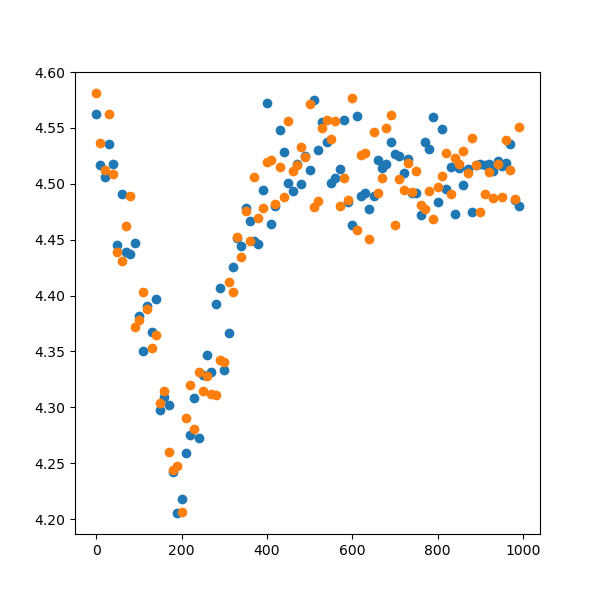

In [10]:
normHistory0 = [np.linalg.norm(a,ord=2) for a in SmallSwarm.Leader[0].InformationMatrixHistory]
normHistory1 = [np.linalg.norm(a,ord=2) for a in SmallSwarm.Leader[1].InformationMatrixHistory]
fig = plt.figure(figsize=(6,6))
t = range(0,SIMULATION_TIME,SAMPLING_TIME)
plt.scatter(t,normHistory0)
plt.scatter(t,normHistory1)
plt.show()

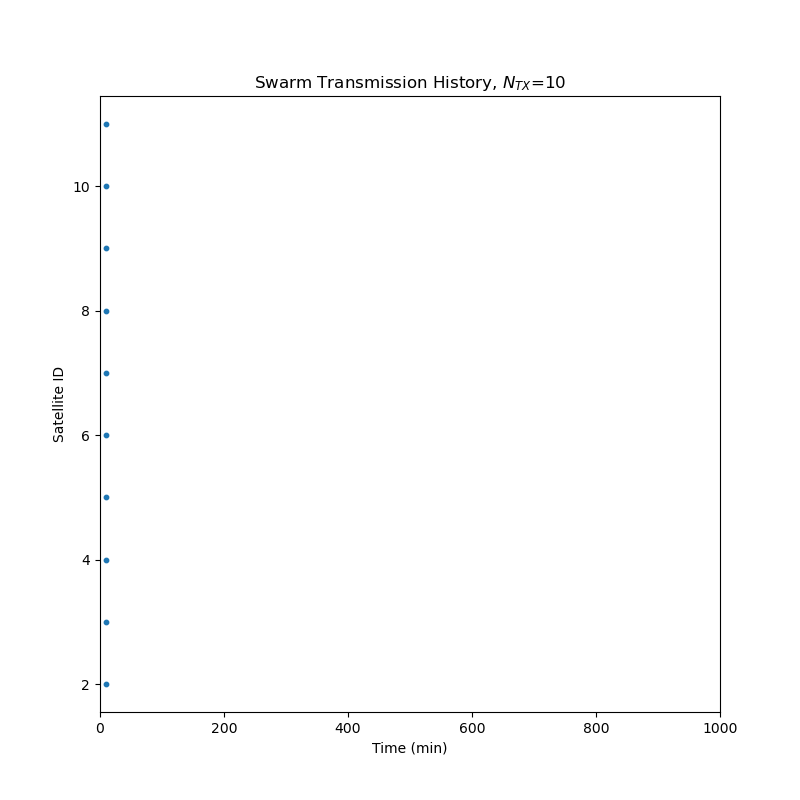

In [11]:
X = []
Y = []
fig = plt.figure(figsize=(8,8))
for satellite in SmallSwarm.Members:
    for entry in satellite.TransmissionHistory:
        Time = entry['Time']
        Y.append(Time)
        X.append(satellite.ID)
plt.scatter(Y,X,s=10)
plt.title("Swarm Transmission History, $N_{TX}$="+f"{len(X)}")
plt.xlabel("Time (min)")
plt.ylabel("Satellite ID")
plt.xlim((0, SIMULATION_TIME))
plt.show()

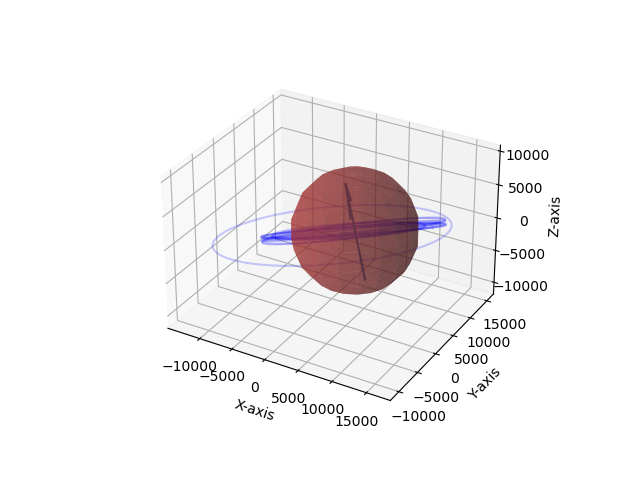

In [12]:
# Redo 11-Swarm with 1 Leader
OrbitGeneratorRNG = np.random.default_rng(rng.integers(0,100000000,1)[0])

Eros = Asteroid(8420,6.687*(10**15),position=np.array([5000,2400,1500]),axis=np.array([-1.5,2,0.4]),period=316.2)
# Satellite Definition
satLeader = Satellite(0,np.array([0,0,0]))
satPhotogeologists = [Satellite(i,np.array([0,0,0])) for i in range (1,7)]
satPropsectors = [Satellite(i,np.array([0,0,0])) for i in range(7,9)]
satPetrologists = [Satellite(i,np.array([0,0,0])) for i in range(9,11)]
satelliteList = [satLeader]
satelliteList.extend(satPhotogeologists)
satelliteList.extend(satPropsectors)
satelliteList.extend(satPetrologists)
SmallSwarm = Swarm(satelliteList)
_ = SmallSwarm.InitializeInformationMatrix()
_ = SmallSwarm.SetFollowerTriggerParameter(1/np.sqrt(SmallSwarm.SwarmSize))
_ = SmallSwarm.SetLeaderTriggerParameter(1/np.sqrt(SmallSwarm.SwarmSize))
ax,fig = Eros.PlotAsteroid(PlotAxis=True)

# Define orbits for each satellite

# Leader - Slightly below geostationary orbit around Eros. Orbit is marginally elliptic
#Leader = SmallSwarm.Leader[0]
rotation1 = Rotation('x',34)
rotation2 = Rotation('y',30)
rotations=[rotation1,rotation2]
SmallSwarm.Leader[0].DefineOrbit(Orbit(Eros.GeoRadius-50,e=0.25,OrbitalPoints=1440,\
                                        Rotations=rotations))
SmallSwarm.Leader[0].Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(SmallSwarm.Leader[0].Orbit.Radius)
SmallSwarm.Leader[0].ComputeOrbitParameters(SmallSwarm.Leader[0].Orbit.OrbitalPeriod)
SmallSwarm.Leader[0].Orbit.ShiftOrbit(0)
ax,fig = Eros.PlotSatelliteOrbit(SmallSwarm.Leader[0],ax,fig)
# Photogeologists - consist of Narrow Field and Wide Field Imagers and Altimeter separated by tens of kilometers to
# kilometers which would be used to determine the nature and distribution of geological units based on texture, albedo,
# color, and apparent stratigraphy as expressed on the surface, from which the nature of the dynamic history and origin
# of the object could be inferred.
for ID in range(1,7):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(35,45,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(35,45,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(12000+OrbitGeneratorRNG.integers(-20,20,1)[0],e=0.02,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)
            
            

# Prospectors - consist of altimeter, magnetometer, Near Infrared, Infrared, and X-ray spectrometers separated
# by tens of kilometers to kilometers which could be used to determine the distribution of 'resources', including Fe/Ni and
# volatiles on pre-selected candidates for 'mining
for ID in range(7,9):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(40,46,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(40,46,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(11500 + OrbitGeneratorRNG.integers(-20,21,1)[0],e=0.05,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)

# Petrologists - Consist of X-ray, Near Infrared, Gamma-ray, Thermal IR, and wide field imager separated by tens of kilometers 
# to kilometers which would be used to determine the abundances and distribution of elements, minerals, and rocks present, 
# from which the nature of geochemical differentiation, origin, and history of the object, and its relationship to a
# 'parent body' could be inferred.
for ID in range(9,11):
    for satellite in SmallSwarm.Members:
        if ID == satellite.ID:
            # Define Orbit
            rotation1 = Rotation('x',OrbitGeneratorRNG.integers(32,40,1)[0]//2)
            rotation2 = Rotation('y',OrbitGeneratorRNG.integers(32,40,1)[0]//2)
            rotations = [rotation1,rotation2]
            orbitObj = Orbit(10000 + OrbitGeneratorRNG.integers(-20,21,1)[0],e=0.1,OrbitalPoints=1440,\
                            Rotations=rotations)
            satellite.DefineOrbit(orbitObj)
            # Compute Orbital Period
            satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
            # Update Orbit Parameters
            satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
            # Shift Orbit
            shift = OrbitGeneratorRNG.integers(-4,5,1)[0]
            satellite.Orbit.ShiftOrbit(shift)
            ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)

In [13]:
# Satellite Event Definitions
eventRNG = np.random.default_rng(rng.integers(0,100000000,1)[0])
PositionNoiseRNG_X = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Y = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Z = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
# 1. Task Completion Events : Valid for follower satellites only, Leader has a dummy task
#StandardTaskEvent = Event(Name="Standard",Priority=lambda x:0.8,Threshold=lambda x:0.9,\
#                              PDF=StandardTaskEventPDF,AdditionalArguments=(k,TMax),ThresholdType='VAR')

# 0. Leader - No specific end task, say 1 month
tMax = 45000
CompletionEvent1 = Event(Name="L1_Task",Priority=lambda x:5, Threshold=lambda x:0.9,\
                       PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED',HoldTime=-1)
SmallSwarm.Leader[0].AddEvents(CompletionEvent1)
# a. Photogeologist - Task completion in the range of 24000 minutes
PhotoGeologistTaskCompletionList = []
for i in range(1,7):
    tMax = 24000 + eventRNG.integers(-2400,2401,1)[0]
    CompletionEvent = Event(Name=f"PG{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                                   PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    PhotoGeologistTaskCompletionList.append(CompletionEvent)
    
# b. Prospector - Task completion event in the range of 30000 minutes
ProspectorTaskCompletionList = []
for i in range(1,3):
    tMax = 30000 + eventRNG.integers(-3000,3001,1)[0]
    CompletionEvent = Event(Name=f"PR{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                           PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    ProspectorTaskCompletionList.append(CompletionEvent)

# c. Petrologist - Task completion event in the range of 20000 minutes
PetrologistTaskCompletionList = []
for i in range(1,3):
    tMax = 20000 + eventRNG.integers(-2000,2001,1)[0]
    CompletionEvent = Event(Name=f"PE{i}_Task",Priority=lambda x:0.9,Threshold=lambda x:0.9,\
                            PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,tMax),ThresholdType='FIXED')
    PetrologistTaskCompletionList.append(CompletionEvent)
TaskCompletionEvents = []
TaskCompletionEvents.extend(PhotoGeologistTaskCompletionList)
TaskCompletionEvents.extend(ProspectorTaskCompletionList)
TaskCompletionEvents.extend(PetrologistTaskCompletionList)
for i in range(1,11):
    SmallSwarm.Members[i].AddEvents(TaskCompletionEvents[i-1])
# 2. Orbit completion events : Valid for all satellites


# Satellite specific orbit completion events
OrbitCompletionEvents = []
matchDict = {0:'L',1:'PG',2:'PG',3:'PG',4:'PG',5:'PG',6:'PG',7:'PR',8:'PR',9:'PE',10:'PE',11:'PE'}
for satellite in (SmallSwarm.Members):
    OrbitEvent = Event(Name=f"{matchDict[satellite.ID]}_Orbit",Priority=lambda x:0.1,Threshold=lambda x:0.95,\
                      PDF=UnitImpulsePDF,\
                       AdditionalArguments=(int(satellite.Orbit.OrbitalPeriod),500),\
                       HoldTime=0)#(satellite.Orbit.OrbitalPeriod//1000))
    OrbitCompletionEvents.append(OrbitEvent)
    # Attach event to satellite
    satellite.AddEvents(OrbitEvent)

# 3. Critical Hardware Failure events : Valid for all satellites
HWFailureEvents = []
for satellite in (SmallSwarm.Members):
    HWFailureEvent = Event(Name=f"{matchDict[satellite.ID]}{satellite.ID}_HWF",Priority=lambda x:1,Threshold=lambda x:0.9,\
                          PDF=HardwareFailureEventPDF,AdditionalArguments=(0.0002,40000,0.00001),\
                           RNG=np.random.default_rng(eventRNG.integers(0,100000,1)[0]),ThresholdType='FIXED')
    # Attach event to satellite
    satellite.AddEvents(HWFailureEvent)
    
# 4. Data offload to Leader events: Valid for follower satellites only
for satellite in (SmallSwarm.Members):
    if satellite not in SmallSwarm.Leader:
        DataEvent = Event(Name=f"{matchDict[satellite.ID]}{satellite.ID}_DO",Priority=lambda x:1,Threshold=lambda x:0.8,\
                          PDF=UnitImpulsePDF,AdditionalArguments=(6000,400),\
                          RNG=np.random.default_rng(eventRNG.integers(0,100000,1)[0]),ThresholdType='FIXED',HoldTime=600)
        satellite.AddEvents(DataEvent)

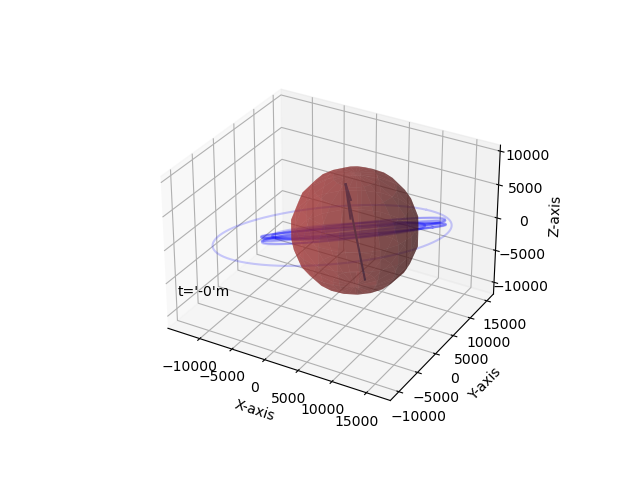

In [14]:
SIMULATION_TIME = 100#50000
SAMPLING_TIME = 10
SAVE_IMG = False
FollowerEpsilon = 0.055
_ = SmallSwarm.InitializeInformationMatrix()
_ = SmallSwarm.SetFollowerTriggerParameter(FollowerEpsilon)
_ = SmallSwarm.SetLeaderTriggerParameter(1)
X0 = Eros.Position[0]
Y0 = Eros.Position[1]
Z0 = Eros.Position[2]
count = 0
t="-0"
ax,fig = Eros.PlotAsteroid(PlotAxis=True)
for satellite in SmallSwarm.Members:
    ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)
text = ax.text(-12000,-14000,-5000,f"{t=}m")
for t in range(0,SIMULATION_TIME,SAMPLING_TIME):
    print(f"{t=}",end='\r')
    tLoc = t
    _ = SmallSwarm.CheckEvents(tLoc)
    X = []
    Y = []
    Z = []
    for satellite in SmallSwarm.Members:
        # Plotting - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        tSat = (t) % int(satellite.Orbit.OrbitalPeriod)
        OrbitValues = satellite.Orbit.GetOrbitValues()
        tValues = satellite.Orbit.GetTimeValues()
        Xf = satellite.Orbit.GetFociValues()[0][0]
        Yf = satellite.Orbit.GetFociValues()[0][1]
        Zf = satellite.Orbit.GetFociValues()[0][2]
        if tSat in tValues:
            tValIndex = tValues.index(tSat)
        else:
            for index,time in enumerate(tValues):
                if tSat>time and tSat<(tValues[(index+1)%len(tValues)]):
                    tValIndex = index
                    break
        Xs = OrbitValues[tValIndex][0]
        Ys = OrbitValues[tValIndex][1]
        Zs = OrbitValues[tValIndex][2]
        XC = Xs - Xf + X0
        YC = Ys - Yf + Y0
        ZC = Zs - Zf + Z0
        coord = np.array([XC,YC,ZC])
        satellite.Position = coord
        X.append(XC)
        Y.append(YC)
        Z.append(ZC)
    if SAVE_IMG == True:
        colors =['blue'] * SmallSwarm.SwarmSize
        colors[0]= 'red'
        colors[2],colors[3],colors[4],colors[5],colors[6],colors[1] = 'orange','orange','orange','orange','orange','orange'
        colors[8],colors[7] = 'green','green'
        colors[10],colors[9] = 'black','black'
        scat_plot = ax.scatter(X,Y,Z,c=colors,marker='o')
        text.set_text(f"{t=}m")
        ax.set_aspect('equal',anchor='C')
        plt.savefig(im_path+str(count)+".png")
        count+=1
        scat_plot.remove()
    # Plotting - END %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Information Matrix - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for satellite in SmallSwarm.Members: # k
        for row in range(0,SmallSwarm.SwarmSize): # Self Satellite , i
            rowSat = SmallSwarm.GetSatelliteByID(row)
            for col in range(0,SmallSwarm.SwarmSize): # Other Satellite, j
                colSat = SmallSwarm.GetSatelliteByID(col)
                if ((satellite.ID == rowSat.ID) and (rowSat.ID == colSat.ID)): # Self Self-Information, i = j = k, all
                        #Self Information Calculation - START
                    AlphaVal = round(1/(len(satellite.Events)+1),4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,0.5),4),\
                                            round(PositionNoiseRNG_Y.normal(0,0.5),4),\
                                            round(PositionNoiseRNG_Z.normal(0,0.5),4)])
                    _ = satellite.UpdateSelfInformationFactor(Alpha=AlphaVal,Beta=BetaVal,Time=tLoc,\
                                                                    Noise=NoiseInfo,dMax=50)
                    #Self Information Calculation - END

                elif ((row == col) and (satellite.ID != row)\
                        and ((satellite in SmallSwarm.Leader)or \
                            (colSat in SmallSwarm.Leader))): # Other Self-Information, i = j != k, only if you or other is leader

                    # Update (Other) Self-Information Calculation - START
                    NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,5),4),\
                                            round(PositionNoiseRNG_Y.normal(0,5),4),\
                                            round(PositionNoiseRNG_Z.normal(0,5),4)])
                    NoiseFactor = np.array([1,1,1])
                    AlphaVal = round(1/(len(rowSat.Events)+1),4)
                    BetaVal = AlphaVal
                    _ = satellite.UpdateOtherSelfInformationFactor(InSat=rowSat,Noise=NoiseInfo,NoiseFactor=NoiseFactor,\
                                                                dMax=50,Estimate=True,Beta=BetaVal)
                        # Update (Other) Self-Information Calculation - END

                    # Cross Information Factors - What you know about them
                    # Satellite is Leader, Self is Satellite
                elif ((satellite in SmallSwarm.Leader) and (col == satellite.ID) and (row != col)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                   dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)
                    # I've given up on describing these situations
                elif ((satellite not in SmallSwarm.Leader) and (col == satellite.ID) and \
                    (rowSat in SmallSwarm.Leader) and (row != col)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)

                    # Cross Information Factors - What they know about you    
                elif((satellite in SmallSwarm.Leader) and (row == satellite.ID) and (row != col)):
                    AlphaVal = 1/(len(satellite.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                PositionNoiseRNG_Y.normal(0,10),\
                                                PositionNoiseRNG_Z.normal(0,10)])
                    _ = satellite.UpdateSelfCrossInformationFactor(InSat=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal,\
                                                                    Invert=True)

                elif ((rowSat in SmallSwarm.Leader) and (rowSat != satellite) and (satellite in SmallSwarm.Leader)):
                    AlphaVal = 1/(len(colSat.Events) + 1)
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = AlphaVal
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                            PositionNoiseRNG_Y.normal(0.0,10),\
                                            PositionNoiseRNG_Z.normal(0.0,10)])
                    _ = satellite.UpdateOtherCrossInformationFactor(InSat=rowSat,InSat2=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                    dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=colSat.MaximumTransmitInterVal)
                elif ((colSat in SmallSwarm.Leader) and (colSat != satellite) and (satellite in SmallSwarm.Leader)):
                    AlphaVal = 1/(len(rowSat.Events) + 1)
                    BetaVal = AlphaVal
                    AlphaVal = round(AlphaVal,4)
                    BetaVal = round(BetaVal,4)
                    NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                            PositionNoiseRNG_Y.normal(0.0,10),\
                                            PositionNoiseRNG_Z.normal(0.0,10)])
                    _ = satellite.UpdateOtherCrossInformationFactor(InSat=colSat,InSat2=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                    dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                    PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)
                
        
    # Update Information Matrix Log - START
        _ = satellite.CheckInformationMatrixJacobian()
        _ = satellite.StoreInformationMatrix()
    # Update Information Matrix Log - END
plt.show()
if SAVE_IMG:
    images = []
    for filename in range(0,count):
        images.append(imageio.imread(im_path + str(filename)+".png"))
    imageio.mimsave(im_path + 'SmallSwarm_Orbit_5.gif', images)
    for filename in range(0,count):
        if os.path.exists(im_path + str(filename)+".png"):
            os.remove(im_path + str(filename)+".png")

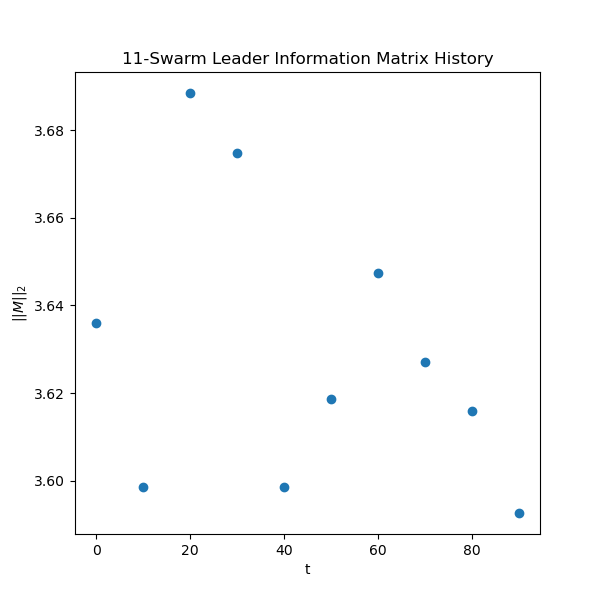

In [15]:
plt.close()
normHistory0 = [np.linalg.norm(a,ord=2) for a in SmallSwarm.Members[0].InformationMatrixHistory]
fig = plt.figure(figsize=(6,6))
t = range(0,SIMULATION_TIME,SAMPLING_TIME)
plt.scatter(t,normHistory0)
plt.title("11-Swarm Leader Information Matrix History")
plt.xlabel("t")
plt.ylabel("$||M||_2$")
plt.show()

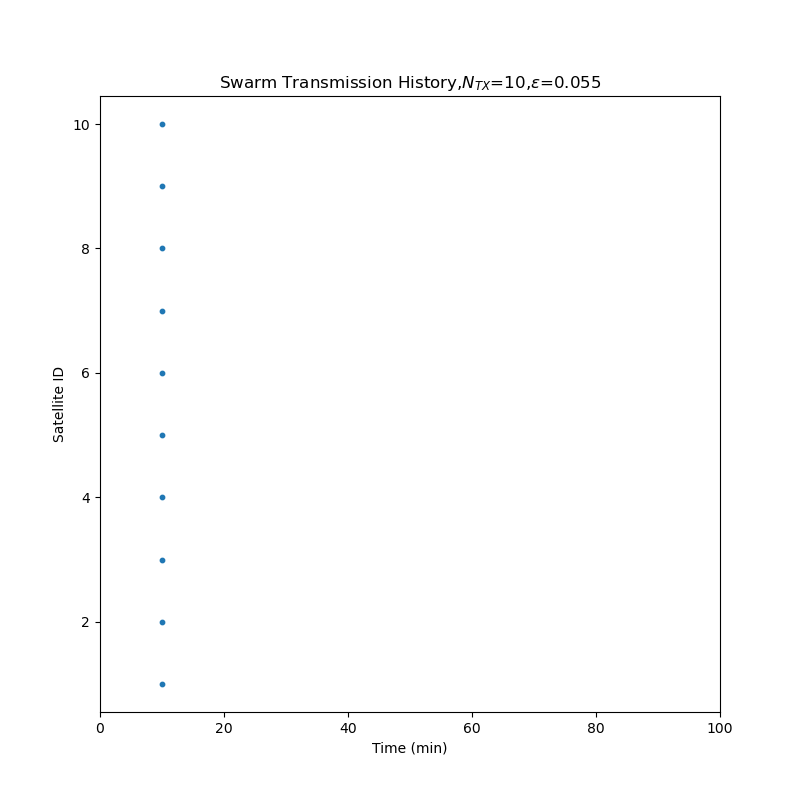

In [16]:
X = []
Y = []
fig = plt.figure(figsize=(8,8))
for satellite in SmallSwarm.Members:
    for entry in satellite.TransmissionHistory:
        Time = entry['Time']
        Y.append(Time)
        X.append(satellite.ID)
plt.scatter(Y,X,s=10)
plt.title(f"Swarm Transmission History,"+ "$N_{TX}$="+f"{len(X)},"+"$\epsilon$="+f"{FollowerEpsilon}")
plt.xlabel("Time (min)")
plt.ylabel("Satellite ID")
plt.xlim((0, SIMULATION_TIME))
plt.show()

In [17]:
# Computation density analysis
N = 100
L = 1 # L is part of N
ComputationsPer = 7
MSize = N**2

# 3(Ne + 1) * N^2
def NumComp(N,L,C=1):
    FollowerDensity = C*(1 + 2*L)
    LeaderDensity = C*((3*N*L) - 2*(L))
    return LeaderDensity,FollowerDensity
N = 1000
x = []
yF = []
yL = []
for L in range(1,1000):
    x.append(L)
    a,b = NumComp(N,L,7)
    yF.append(b)
    yL.append(a)

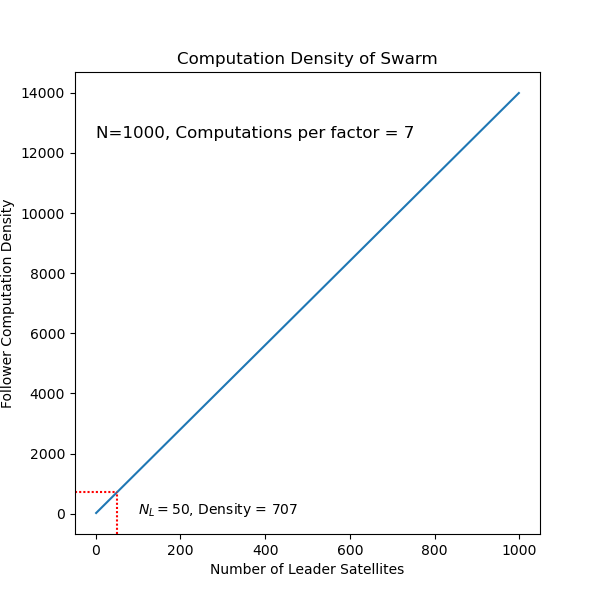

In [18]:
plt.figure(figsize=(6,6))
plt.plot(x,yF)
#plt.plot(x,yL)
plt.title("Computation Density of Swarm")
plt.xlabel("Number of Leader Satellites")
plt.ylabel("Follower Computation Density")
plt.text(0,12500,"N=1000, Computations per factor = 7",fontsize=12)
plt.axvline(50,0,0.0904,dashes=(1,1),c='r')
plt.axhline(707,0,0.0904,dashes=(1,1),c='r')
plt.text(100,0,"$N_L = 50$, Density = 707")
plt.show()

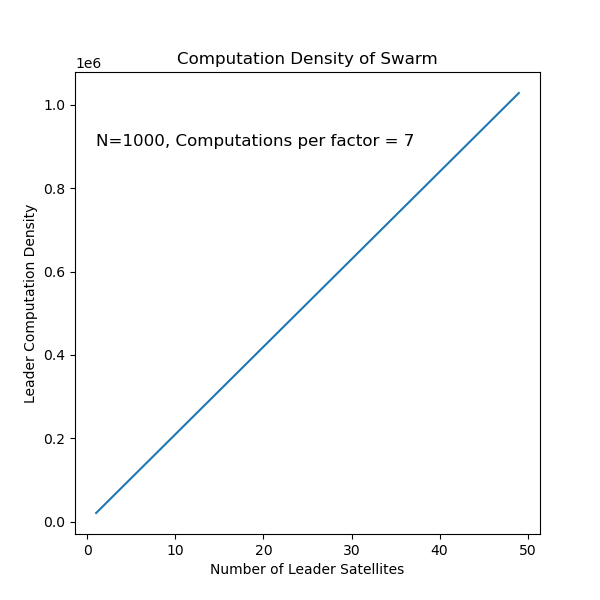

In [19]:
plt.figure(figsize=(6,6))
plt.plot(x[0:49],yL[0:49])
plt.title("Computation Density of Swarm")
plt.xlabel("Number of Leader Satellites")
plt.ylabel("Leader Computation Density")
plt.text(1,900000,"N=1000, Computations per factor = 7",fontsize=12)
plt.show()

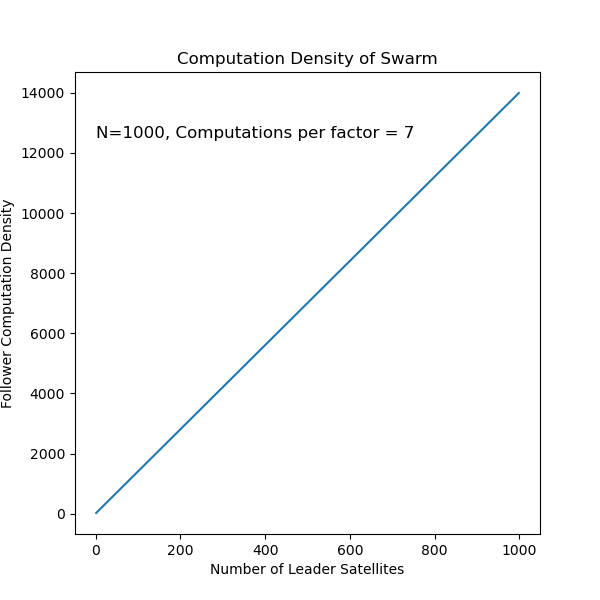

In [20]:
plt.figure(figsize=(6,6))
plt.plot(x,yF)
#plt.plot(x,yL)
plt.title("Computation Density of Swarm")
plt.xlabel("Number of Leader Satellites")
plt.ylabel("Follower Computation Density")
plt.text(0,12500,"N=1000, Computations per factor = 7",fontsize=12)
plt.show()

In [21]:
# Construct a 100-satellite swarm with 100 followers and 10 leaders

# Orbital parameters are not really relevant here as the intent is to \
# verify the control strategy and the radio range is set to maximum.

# Regarding satellite events, I'm thinking generate a bunch of random events based on various PDF and via
# parameters map them to the satellites. At least 10 events per satellite including HW failure, Orbit Completion,
# Task Completion

# 1. Satellite Definitions
# 10 Leader Satellites numbered 0 to 9, 90 follower satellites numbers 10 to 99
SatList = []
N_LEADER = 5 # Originally 10
N_FOLLOWER = 45 # Originally 90
PERIODIC = False
for i in range(0,(N_LEADER+N_FOLLOWER)):
    satL = Satellite(i,np.array([0,0,0]))
    SatList.append(satL)
BigSwarm = Swarm(SatList)
for i in range(1,N_LEADER):
    BigSwarm.AddLeader(BigSwarm.Members[i])
_ = BigSwarm.InitializeInformationMatrix()
_ = BigSwarm.SetFollowerTriggerParameter(3)#1/np.sqrt(BigSwarm.SwarmSize))
_ = BigSwarm.SetLeaderTriggerParameter(1)#/np.sqrt(BigSwarm.SwarmSize))

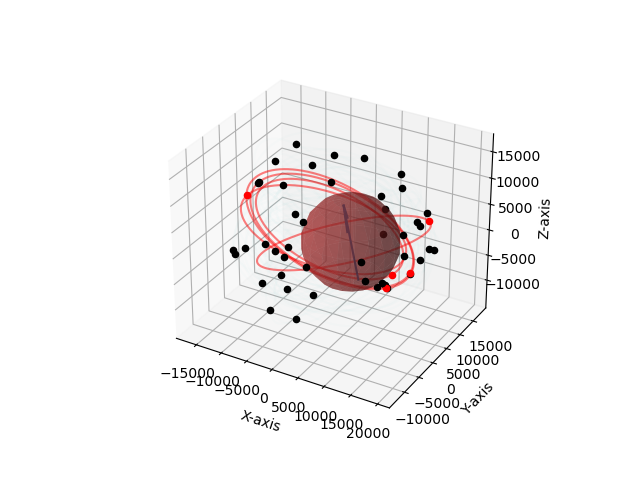

In [22]:
# Generating orbits for all the satellites
OG_RNG = np.random.default_rng(rng.integers(0,100000000,1)[0])
Eros = Asteroid(8420,6.687*(10**15),position=np.array([5000,2400,1500]),axis=np.array([-1.5,2,0.4]),period=316.2)
ax,fig = Eros.PlotAsteroid(PlotAxis=True)

# Leader Orbits
for satellite in BigSwarm.Leader:
    rotation1 = Rotation('x',OG_RNG.integers(-45,46,1)[0])
    rotation2 = Rotation('y',OG_RNG.integers(-45,46,1)[0])
    rotations = [rotation1,rotation2]
    distance = OG_RNG.integers(-100,2000,1)[0]
    eccentricity = OG_RNG.random()/10 # Eccentricity between 0 and 0.1
    satellite.DefineOrbit(Orbit(Eros.GeoRadius+distance,e=eccentricity,OrbitalPoints=2880,Rotations=rotations))
    satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
    satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
    shift = OG_RNG.integers(-360,361,1)[0] # Up to 45 degrees either way so 90 degrees total
    satellite.Orbit.ShiftOrbit(shift)
    
# Follower Orbits
for satellite in BigSwarm.Members:
    if satellite not in BigSwarm.Leader:
        rotation1 = Rotation('x',OG_RNG.integers(-45,46,1)[0])
    rotation2 = Rotation('y',OG_RNG.integers(-45,46,1)[0])
    rotations = [rotation1,rotation2]
    distance = OG_RNG.integers(-3000,-251,1)[0]
    eccentricity = OG_RNG.random()/2 # Eccentricity between 0 and 0.5
    satellite.DefineOrbit(Orbit(Eros.GeoRadius+distance,e=eccentricity,OrbitalPoints=2880,Rotations=rotations))
    satellite.Orbit.OrbitalPeriod = Eros.ComputeSatellitePeriod(satellite.Orbit.Radius)
    satellite.ComputeOrbitParameters(satellite.Orbit.OrbitalPeriod)
    shift = OG_RNG.integers(-1440,1441,1)[0] # Up to 180 degrees either way so 360 degrees total
    satellite.Orbit.ShiftOrbit(shift)
    
# Plot all the orbits with initial position
for satellite in BigSwarm.Members:
    if satellite in BigSwarm.Leader:
        OrbitColor = 'r'
        MarkerColor = 'r'
        OrbitAlpha = 0.5
    else:
        OrbitColor = 'c'
        MarkerColor = 'k'
        OrbitAlpha = 0.01
    ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig,PlotInitialPosition=True,\
                                     SatelliteOrbitColor=OrbitColor,SatelliteMarkerColor=MarkerColor,OrbitAlpha=OrbitAlpha)
plt.show()

In [23]:
# Create and attach events to all satellites

# Define some standard random functions

def GaussianPDF(t,dt,mean,sigma):
    '''f(t) = (1/sigma*sqrt(2*pi))*e^((-0.5*(t-mean)/sigma)^2)'''
    m = mean
    s = sigma
    
    retVal = (1/(s*np.sqrt(2*np.pi)))*np.exp(-0.5*((t-m)/s)**2)
    return retVal

def UniformPDF(t,dt,maxP,minP):
    '''f(t) = 1/(b-a)'''
    retVal = (1/(maxP-minP)) 
    return retVal

In [24]:
# Satellite Event Definitions
eventRNG = np.random.default_rng(rng.integers(0,100000000,1)[0])
PositionNoiseRNG_X = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Y = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
PositionNoiseRNG_Z = np.random.default_rng(eventRNG.integers(0,100000,1)[0])
# 1. Task Completion Events : Valid for all satellites, leaders will be closer to 45000 minutes
#StandardTaskEvent = Event(Name="Standard",Priority=lambda x:0.8,Threshold=lambda x:0.9,\
#                              PDF=StandardTaskEventPDF,AdditionalArguments=(k,TMax),ThresholdType='VAR')

# Leader - No specific end task, say 1 month
tMax = 9000
for satellite in BigSwarm.Leader:
    CompletionTime = tMax + eventRNG.integers(-500,501,1)[0]
    CompletionEvent = Event(Name=f"L{satellite.ID}_Task",Priority=lambda x:20, Threshold=lambda x:0.9,\
                       PDF=StandardTaskEventPDF,AdditionalArguments=(0.95,CompletionTime),ThresholdType='FIXED',HoldTime=10,\
                           SingleTrigger=True)
    satellite.AddEvents(CompletionEvent)
    
# Follower - End task time between 4500 and 7000 minutes
for satellite in BigSwarm.Members:
    if satellite not in BigSwarm.Leader:
        CompletionTime = eventRNG.integers(4500,7001,1)[0]
        CompletionEvent = Event(Name=f"F{satellite.ID}_Task",Priority=lambda x:5, Threshold=lambda x:0.9,\
                               PDF=StandardTaskEventPDF,AdditionalArguments=(0.9,CompletionTime),ThresholdType='FIXED',\
                                HoldTime=-1,SingleTrigger=True)
        satellite.AddEvents(CompletionEvent)
        
# 2. Gaussian events: Say 5 for each follower
for satellite in BigSwarm.Members:
    if satellite not in BigSwarm.Leader:
        for i in range(1,6):
            mean = eventRNG.integers(1000,25000,1)[0]
            std = eventRNG.integers(mean//20,mean//10,1)[0]
            prio = eventRNG.integers(1,10,1)[0]
            GaussianEvent = Event(Name=f"F{satellite.ID}_Gaussian{i}",Priority=lambda x:int(2),Threshold=lambda x:0.5,\
                                 PDF=GaussianPDF,AdditionalArguments=(mean,std),ThresholdType='VARIABLE',HoldTime=100)
            satellite.AddEvents(GaussianEvent)

# 3. Uniform events: Say 5 for each follower
for satellite in BigSwarm.Members:
    if satellite not in BigSwarm.Leader:
        for i in range(1,6):
            maxP = round(eventRNG.random(),4)
            minP = round(eventRNG.random(),4)
            if minP > maxP:
                minP,maxP = maxP,minP
            prio = eventRNG.integers(1,10,1)[0]
            UniformEvent = Event(Name=f"F{satellite.ID}_Uniform{i}",Priority=lambda x:int(2),Threshold=lambda x:0.99,\
                                PDF=UniformPDF,AdditionalArguments=(maxP,minP),ThresholdType='VARIABLE',HoldTime=100)
            satellite.AddEvents(UniformEvent)

# 4. Periodic event: 1 high priority periodic event per follower satellite
if PERIODIC == True:
    for satellite in (BigSwarm.Members):
        if satellite not in BigSwarm.Leader:
            DataEvent = Event(Name=f"ID{satellite.ID}_Periodic",Priority=lambda x:20,Threshold=lambda x:0.8,\
                              PDF=UnitImpulsePDF,AdditionalArguments=(500,50),\
                              RNG=np.random.default_rng(eventRNG.integers(0,100000,1)[0]),ThresholdType='FIXED',HoldTime=0)
            satellite.AddEvents(DataEvent)

In [25]:
if False:
    #normHistory0 = [np.linalg.norm(a) for a in BigSwarm.Leader[0].InformationMatrixHistory]
    #fig = plt.figure(figsize=(6,6))
    #t = range(0,SIMULATION_TIME,SAMPLING_TIME)
    #plt.scatter(t,normHistory0)
    #plt.show()
    fig, axs = plt.subplots(5,2)
    fig.set_size_inches(10,12)
    t = range(0,SIMULATION_TIME,SAMPLING_TIME)
    for i in range(len(BigSwarm.Leader)):
        normHistory = [np.linalg.norm(a,ord=2) for a in BigSwarm.Leader[i].InformationMatrixHistory]
        row = i//2
        col = (i%2)
        axs[row,col].scatter(t,normHistory)
        axs[row,col].set_title(f"Info. Matrix - Leader {i}")
    for ax in axs.flat:
        ax.set(xlabel="t",ylabel="$\eta$")
    for ax in axs.flat:
        ax.label_outer()

In [26]:
if False:
    X = []
    Y = []
    fig = plt.figure(figsize=(8,8),dpi=120)
    for satellite in BigSwarm.Members:
        for entry in satellite.TransmissionHistory:
            Time = entry['Time']
            Y.append(Time)
            X.append(satellite.ID)
    plt.scatter(Y,X,s=10)
    plt.title(f"Swarm Transmission History, $N_{TX}$={len(X)}")
    plt.xlabel("Time (min)")
    plt.ylabel("Satellite ID")
    plt.xlim((0, SIMULATION_TIME))
    plt.show()

In [27]:
if False:
    refSat = BigSwarm.Leader[0]
    t = range(0,SIMULATION_TIME,SAMPLING_TIME)
    fig = plt.figure(dpi=120)
    #ax = fig.subplots(BigSwarm.SwarmSize,BigSwarm.SwarmSize,sharex=True)
    ax = fig.subplots(5,5,sharex=True)
    #for i in range(BigSwarm.SwarmSize):
    for i in range(5):
        #for j in range(BigSwarm.SwarmSize):
        for j in range(5):
            yVal = [a[i][j] for a in refSat.InformationMatrixHistory]
            ax[i,j].scatter(t,yVal)
            ax[i,j].set_title(f"a_{j}{i}")
    plt.suptitle(f"Satellite {refSat.ID} Information Matrix Values")
    #plt.savefig("100x100.pdf")
    plt.show()

In [35]:
if False:
    X = []
    Y = []
    fig = plt.figure(figsize=(8,8))
    for satellite in BigSwarm.Members:
        for entry in satellite.TransmissionHistory:
            Time = entry['Time']
            Y.append(Time)
            X.append(satellite.ID)
    plt.scatter(Y,X,s=10)
    plt.title(f"Swarm Transmission History, $N_{TX}$={len(X)}")
    plt.xlabel("Time (min)")
    plt.ylabel("Satellite ID")
    plt.xlim((0, SIMULATION_TIME))
    plt.show()

In [36]:
BigSwarmOriginal = copy.deepcopy(BigSwarm)
# Empirically determine epsilon value by iterating over a range of trigger factors. Extremely time-consuming
for followerTrigFactor in range(1):    
    
    SIMULATION_TIME = 10000
    SAMPLING_TIME = 10
    SAVE_IMG = False
    
    if 'BigSwarm' in locals():
        del BigSwarm
    
    BigSwarm = copy.deepcopy(BigSwarmOriginal)
    TrigParam = 0.135 # 0.088 for N=10, 0.15 for N=50 leads to N_TX = 80, 0.12 -> 119, 0.135 -> 106, 0.01
    LeaderTrigParam = 0.135
    TrigParam = round(TrigParam,4)
    LeaderTrigParam = round(LeaderTrigParam,4)
    
    _ = BigSwarm.InitializeInformationMatrix()
    _ = BigSwarm.SetMinimumTransmitInterval(500)
    _ = BigSwarm.SetMaximumTransmitInterval(15000)
    _ = BigSwarm.UpdateIdenticalTransmitFlag(False)
    _ = BigSwarm.SetFollowerTriggerParameter(TrigParam)
    _ = BigSwarm.SetLeaderTriggerParameter(LeaderTrigParam)

    ExtraNameString = ""
    X0 = Eros.Position[0]
    Y0 = Eros.Position[1]
    Z0 = Eros.Position[2]
    count = 0
    counter = 1
    t="-0"
    #ax,fig = Eros.PlotAsteroid(PlotAxis=True)
    #for satellite in BigSwarm.Members:
        #ax,fig = Eros.PlotSatelliteOrbit(satellite,ax,fig)
    #text = ax.text(-12000,-14000,-5000,f"{t=}m")
    for t in range(0,SIMULATION_TIME,SAMPLING_TIME):
        if (t%100) == 0:
            print(f"{TrigParam=},{t=}",end='\r')
        tLoc = t
        _ = BigSwarm.CheckEvents(tLoc)
        X = []
        Y = []
        Z = []
        for satellite in BigSwarm.Members:
            # Update Positions - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
            tSat = (t) % int(satellite.Orbit.OrbitalPeriod)
            OrbitValues = satellite.Orbit.GetOrbitValues()
            tValues = satellite.Orbit.GetTimeValues()
            Xf = satellite.Orbit.GetFociValues()[0][0]
            Yf = satellite.Orbit.GetFociValues()[0][1]
            Zf = satellite.Orbit.GetFociValues()[0][2]
            if tSat in tValues:
                tValIndex = tValues.index(tSat)
            else:
                for index,time in enumerate(tValues):
                    if tSat>time and tSat<(tValues[(index+1)%len(tValues)]):
                        tValIndex = index
                        break
            Xs = OrbitValues[tValIndex][0]
            Ys = OrbitValues[tValIndex][1]
            Zs = OrbitValues[tValIndex][2]
            XC = Xs - Xf + X0
            YC = Ys - Yf + Y0
            ZC = Zs - Zf + Z0
            coord = np.array([XC,YC,ZC])
            satellite.Position = coord
        del tSat, OrbitValues,tValues,Xf,Yf,Zf,Xs,Ys,Zs,XC,YC,ZC,coord
        # Update Positions - END %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        
    # EVENT ERROR INDUCEMENT - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        # Choose Time
        InduceError_b = False
        MinTime = -100
        MaxTime = -100
        if (MinTime <= t <= MaxTime):
            InduceError_b = True
        else:
            InduceError_b = False
        # Choose Satellite
        #satID = eventRNG.integers(0,len(BigSwarm.Members),1)[0]
        satID = 10
        if satID >= 0:
            # Choose Event
            #eventID = eventRNG.integers(0,len(BigSwarm.Members[satID].Events),1)[0]
            eventID = [3,4,5,6,7,8]
            if InduceError_b == True:
                BigSwarm.Members[satID].SetTriggerCondition(0.1)
                BigSwarm.Members[satID].MinimumTransmitInterval = 0
                if isinstance(eventID,int):
                    BigSwarm.Members[satID].Events[eventID].Error = True
                elif isinstance(eventID,list):
                    for ID in eventID:
                        BigSwarm.Members[satID].Events[ID].Error = True
            # Reset Error
            elif InduceError_b == False:
                BigSwarm.Members[satID].SetTriggerCondition(TrigParam)
                BigSwarm.Members[satID].MinimumTransmitInterval = 500
                if isinstance(eventID,int):
                    BigSwarm.Members[satID].Events[eventID].Error = False
                elif isinstance(eventID,list):
                    for ID in eventID:
                        BigSwarm.Members[satID].Events[ID].Error = False
        
    # EVENT ERROR INDUCEMENT - END   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
    # Information Matrix - START %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        for satellite in BigSwarm.Members: # k
            for row in range(0,BigSwarm.SwarmSize): # Self Satellite , i
                rowSat = BigSwarm.GetSatelliteByID(row)
                for col in range(0,BigSwarm.SwarmSize): # Other Satellite, j
                    colSat = BigSwarm.GetSatelliteByID(col)
                    if ((satellite.ID == rowSat.ID) and (rowSat.ID == colSat.ID)): # Self Self-Information, i = j = k, all
                         #Self Information Calculation - START
                        AlphaVal = round(1/(len(satellite.Events)+1),4)
                        BetaVal = AlphaVal
                        NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,0.5),4),\
                                                round(PositionNoiseRNG_Y.normal(0,0.5),4),\
                                                round(PositionNoiseRNG_Z.normal(0,0.5),4)])
                        _ = satellite.UpdateSelfInformationFactor(Alpha=AlphaVal,Beta=BetaVal,Time=tLoc,\
                                                                    Noise=NoiseInfo,dMax=50)
                        #Self Information Calculation - END

                    elif ((row == col) and (satellite.ID != row)\
                          and ((satellite in BigSwarm.Leader)or \
                               (colSat in BigSwarm.Leader))): # Other Self-Information, i = j != k, only if you or other is leader

                        # Update (Other) Self-Information Calculation - START
                        NoiseInfo = np.array([round(PositionNoiseRNG_X.normal(0,5),4),\
                                                round(PositionNoiseRNG_Y.normal(0,5),4),\
                                                round(PositionNoiseRNG_Z.normal(0,5),4)])
                        NoiseFactor = np.array([1,1,1])
                        AlphaVal = round(1/(len(rowSat.Events)+1),4)
                        BetaVal = AlphaVal
                        _ = satellite.UpdateOtherSelfInformationFactor(InSat=rowSat,Noise=NoiseInfo,NoiseFactor=NoiseFactor,\
                                                                dMax=50,Estimate=True,Beta=BetaVal)
                        # Update (Other) Self-Information Calculation - END

                    # Cross Information Factors - What you know about them
                    # Satellite is Leader, Self is Satellite
                    elif ((satellite in BigSwarm.Leader) and (col == satellite.ID) and (row != col)):
                        AlphaVal = 1/(len(rowSat.Events) + 1)
                        AlphaVal = round(AlphaVal,4)
                        BetaVal = AlphaVal
                        NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                  PositionNoiseRNG_Y.normal(0,10),\
                                                  PositionNoiseRNG_Z.normal(0,10)])
                        _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                   dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)
                    # I've given up on describing these situations
                    elif ((satellite not in BigSwarm.Leader) and (col == satellite.ID) and \
                        (rowSat in BigSwarm.Leader) and (row != col)):
                        AlphaVal = 1/(len(rowSat.Events) + 1)
                        AlphaVal = round(AlphaVal,4)
                        BetaVal = AlphaVal
                        NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                  PositionNoiseRNG_Y.normal(0,10),\
                                                  PositionNoiseRNG_Z.normal(0,10)])
                        _ = satellite.UpdateSelfCrossInformationFactor(InSat=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                   dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)

                    # Cross Information Factors - What they know about you    
                    elif((satellite in BigSwarm.Leader) and (row == satellite.ID) and (row != col)):
                        AlphaVal = 1/(len(satellite.Events) + 1)
                        AlphaVal = round(AlphaVal,4)
                        BetaVal = AlphaVal
                        NoiseInfo = np.array([PositionNoiseRNG_X.normal(0,10),\
                                                  PositionNoiseRNG_Y.normal(0,10),\
                                                  PositionNoiseRNG_Z.normal(0,10)])
                        _ = satellite.UpdateSelfCrossInformationFactor(InSat=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                   dMax=50,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal,\
                                                                       Invert=True)

                    elif ((rowSat in BigSwarm.Leader) and (rowSat != satellite) and (satellite in BigSwarm.Leader)):
                        AlphaVal = 1/(len(colSat.Events) + 1)
                        BetaVal = AlphaVal
                        AlphaVal = round(AlphaVal,4)
                        BetaVal = round(BetaVal,4)
                        NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                              PositionNoiseRNG_Y.normal(0.0,10),\
                                              PositionNoiseRNG_Z.normal(0.0,10)])
                        _ = satellite.UpdateOtherCrossInformationFactor(InSat=rowSat,InSat2=colSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                       dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=colSat.MaximumTransmitInterVal)
                    elif ((colSat in BigSwarm.Leader) and (colSat != satellite) and (satellite in BigSwarm.Leader)):
                        AlphaVal = 1/(len(rowSat.Events) + 1)
                        BetaVal = AlphaVal
                        AlphaVal = round(AlphaVal,4)
                        BetaVal = round(BetaVal,4)
                        NoiseInfo = np.array([PositionNoiseRNG_X.normal(0.0,10),\
                                              PositionNoiseRNG_Y.normal(0.0,10),\
                                              PositionNoiseRNG_Z.normal(0.0,10)])
                        _ = satellite.UpdateOtherCrossInformationFactor(InSat=colSat,InSat2=rowSat,Time=tLoc,Alpha=AlphaVal,Beta=BetaVal,\
                                                                       dMax=25,PosNoise=NoiseInfo,EventsKnown=True,Estimate=True,\
                                                                       PositionKnown=True,delTMax=rowSat.MaximumTransmitInterVal)

                    # Update Information Matrix Log - START
            _ = satellite.CheckInformationMatrixJacobian()
            _ = satellite.StoreInformationMatrix()
            # Update Information Matrix Log - END
    if SAVE_IMG:
        X = []
        Y = []
        fig = plt.figure(figsize=(8,8))
        for satellite in BigSwarm.Members:
            for entry in satellite.TransmissionHistory:
                Time = entry['Time']
                Y.append(Time)
                X.append(satellite.ID)
        plt.scatter(Y,X,s=10)
        plt.title(f"Swarm Transmission History,"+ "$N_{TX}$"+f"={len(X)}, Eta_F = {TrigParam}")
        plt.xlabel("Time (min)")
        plt.ylabel("Satellite ID")
        plt.xlim((0, SIMULATION_TIME))
        FILE_ID = str(followerTrigFactor)
        if len(FILE_ID) == 1:
            FILE_ID = "0" + FILE_ID
        plt.savefig(f"{im_path}{BigSwarm.SwarmSize}_Swarm/Tx_History/{ExtraNameString}{FILE_ID}_{TrigParam}_Eta.png")
        #plt.show()
        plt.close()
        #fig, axs = plt.subplots(3,2) # CHANGE ROWS DEPENDING ON N_LEADER
        t = range(0,SIMULATION_TIME,SAMPLING_TIME)
        fig,ax = plt.subplots()
        ax.set_xlabel("t")
        ax.set_ylabel("$\eta$")
        for i in range(len(BigSwarm.Members)):
            normHistory = [np.linalg.norm(a,ord=2) for a in BigSwarm.Members[i].InformationMatrixHistory]
            ax.scatter(x=t,y=normHistory,s=12)
            ax.set_title(f"Info. Matrix - ID {i}")
            if BigSwarm.Members[i] in BigSwarm.Leader:
                TrigParName = LeaderTrigParam
            else:
                TrigParName = TrigParam
            fig.savefig(f"{im_path}{BigSwarm.SwarmSize}_Swarm/M_Satellite/{ExtraNameString}ID{i}_{FILE_ID}_{TrigParName}_Eta.png")
            ax.clear()
            plt.close()

25


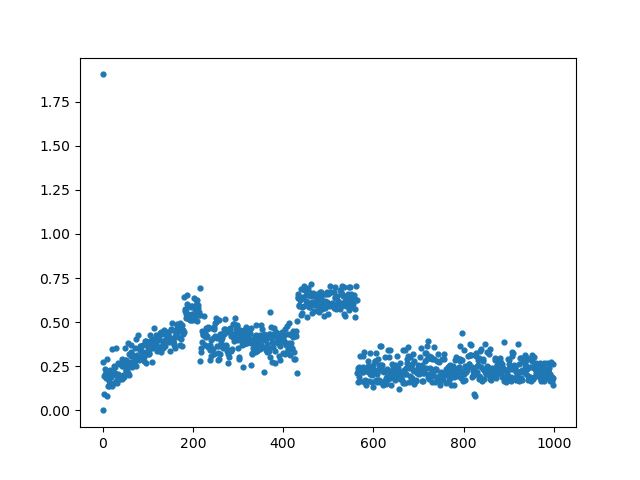

In [39]:
a = BigSwarm.Members[10]
fig1, ax1 = plt.subplots()
sumPrio = 0
for event in a.Events:
    sumPrio+=event.Priority(0)
print(sumPrio)
ax1.scatter(range(len(a.U_DIFF_History)),a.U_DIFF_History,s=12)


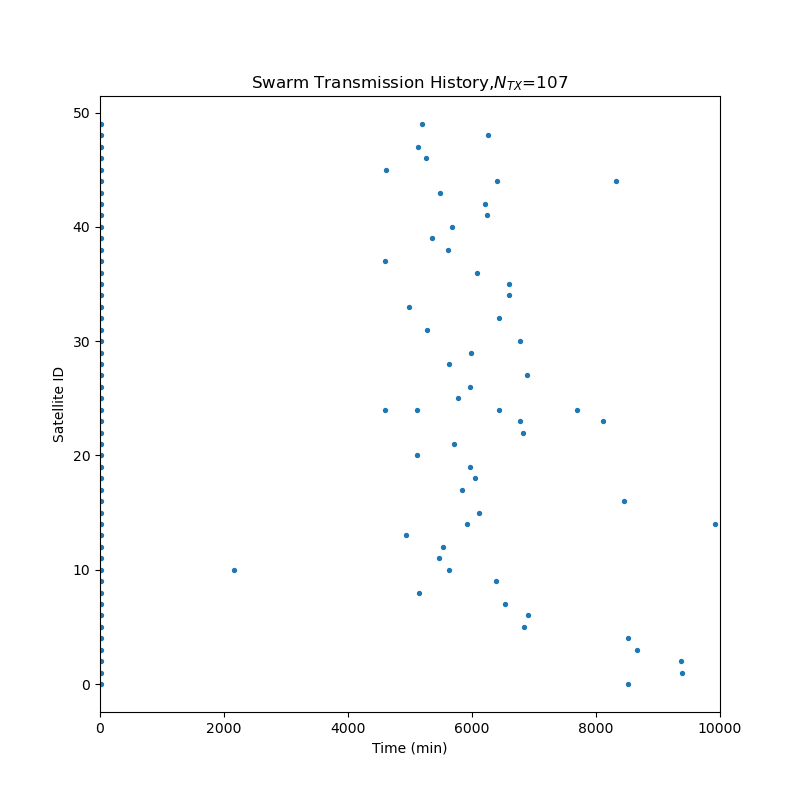

In [38]:
X = []
Y = []
fig = plt.figure(figsize=(8,8))
for satellite in BigSwarm.Members:
    for entry in satellite.TransmissionHistory:
        Time = entry['Time']
        Y.append(Time)
        X.append(satellite.ID)
plt.scatter(Y,X,s=8)
plt.title(f"Swarm Transmission History,"+ "$N_{TX}$="+f"{len(X)}")
plt.xlabel("Time (min)")
plt.ylabel("Satellite ID")
plt.xlim((0, SIMULATION_TIME))
plt.show()